### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import array as array
from scipy.stats import pearsonr
%matplotlib inline
import seaborn as sns
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
#pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
### Function

In [3]:
def wAvrgAggr(df, cName):
    totalW = 0.0
    totVal = 0.0
    for value, weight in zip(df[cName], df['TotalPop']):
        totVal += float(value) * float(weight)
        totalW += weight
    return totVal/totalW

def sumAggregation(df, cName):
    return df[cName].sum()

def weighted_median(df, val):
    df_sorted = df.sort_values(val)
    cumsum = df_sorted['TotalPop'].cumsum()
    cutoff = df_sorted['TotalPop'].sum() / 2.
    return df_sorted[cumsum >= cutoff][val].iloc[0]

### Data Loading

In [4]:
demographics=pd.read_csv("data/income/demographic.csv")
c_results=pd.read_csv("data/output/countyData.csv")
s_results=pd.read_csv("data/output/stateData.csv")

### Data Cleaning - Demographics

In [5]:
#Porto Rico doesnt vote
demographics.drop(demographics[demographics.State=='Puerto Rico'].index, inplace=True)

#Drop Columns
demographics.drop(['CountyId','IncomeErr','IncomePerCapErr'], axis=1, inplace=True)

#General Data adjustment for mapping
demographics['County'] = demographics['County'].str.replace(' County', '')
demographics['County'] = demographics['County'].str.replace(' Parish', '')
demographics['County'] = demographics['County'].str.replace(' parish', '')

#Virginia
m = demographics['State'] == 'Virginia'
demographics.loc[m, 'County'] = demographics.loc[m, 'County'].replace({' city': ''}, regex=True)
demographics.loc[m, 'County'] = demographics.loc[m, 'County'].replace({' City': ''}, regex=True)

#Alaska
m = demographics['State'] == 'Alaska'
demographics.loc[m, 'County'] = 'Alaska'

#Sorting
demographics.sort_values(by=['State', 'County'], inplace=True, ascending=True)

### Data Cleaning - c_result

In [6]:
#Drop NA for Now until fix
c_results=c_results.dropna()

#TEMPORARY FIX /// Drop all Alaska Except one
c_results.drop(c_results[(c_results.state=='Alaska') & (c_results.county_id > 13)].index, inplace=True)


### Data Cleaning - s_result

In [7]:
#Drop NA for Now until fix
s_results=s_results.dropna()

### Data County Merge

In [8]:
County_merged=pd.merge(right=demographics, left=c_results, right_on=['State','County'], left_on=['state','county'])
County_merged.drop(['State', 'County'], axis=1, inplace=True)
County_merged['state_id'] = County_merged['state_id'].astype("Int32")
County_merged['county_id'] = County_merged['county_id'].astype("Int32")
County_merged.shape

#Alaska Fix
g = County_merged.groupby('state')
for state, group in g:
    if state == 'Alaska':
        # Note that TotalPop should be aggregated last, as it is used in the wAvrg
        sumAgg = ['Men','Women','TotalPop']
        wAvgAgg = ['IncomePerCap', 'Hispanic', 'White','Black','Native','Asian','Pacific', 'Poverty', 'ChildPoverty','Unemployment']
        wMedian = ['Income']
        for col in wMedian: 
            newVal = weighted_median(group, col)
            County_merged.loc[(County_merged['state'] == state), col] = newVal
        for col in wAvgAgg:  
            newVal = wAvrgAggr(group, col)
            County_merged.loc[(County_merged['state'] == state), col] = newVal
        for col in sumAgg:
            newVal = sumAggregation(group, col)
            County_merged.loc[(County_merged['state'] == state), col] = newVal
            

County_merged.to_csv (r'data/output/Merged_County_V1.csv', index = False, header=True)

### Data State Merge

In [9]:
stateData = County_merged.copy()
g = stateData.groupby('state')
for state, group in g:
    # Note that TotalPop should be aggregated last, as it is used in the wAvrg
    sumAgg = ['Men','Women','TotalPop','DEM_votes','REP_votes']
    wAvgAgg = ['normalized_election_outcome', 'IncomePerCap', 'Hispanic', 'White','Black','Native','Asian','Pacific', 'Poverty', 'ChildPoverty','Unemployment']
    wMedian = ['Income']
    for col in wMedian: 
        newVal = weighted_median(group, col)
        stateData.loc[(stateData['state'] == state), col] = newVal
    for col in wAvgAgg:  
        newVal = wAvrgAggr(group, col)
        stateData.loc[(stateData['state'] == state), col] = newVal
    for col in sumAgg:
        newVal = sumAggregation(group, col)
        stateData.loc[(stateData['state'] == state), col] = newVal
    
    
    
    # And aggregate the
stateData = stateData[['state','state_id','DEM_votes','REP_votes','normalized_election_outcome', 'TotalPop','Men','Women','Hispanic','White','Black','Native','Asian','Pacific','IncomePerCap', 'Income','Poverty','ChildPoverty','Unemployment']]
stateData = stateData.drop_duplicates()
stateData = stateData.sort_values(by=['state_id'])
stateData['state_id'] = stateData['state_id'].astype("Int32")
stateData = stateData.reset_index(drop=True)


In [10]:
stateData= stateData.sort_values(by=['normalized_election_outcome'])
stateData.to_csv (r'data/output/Merged_State_V1.csv', index = False, header=True)

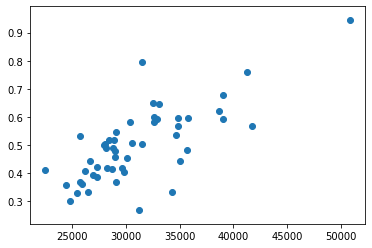

In [11]:
plt.scatter(stateData['IncomePerCap'], stateData['normalized_election_outcome']);